In [1]:
#!pip install --trusted-host pypi.org --trusted-host pypi.python.org --trusted-host files.pythonhosted.org --trusted-host files.pythonhosted.org -r requirements.txt --cert DSOCA50.pem --cert DSOVisibilityCA.pem --cert cacert.pem
#!pip uninstall dgl 
#!pip install dgl -f https://data.dgl.ai/wheels/cu117/repo.html --trusted-host pypi.org --trusted-host pypi.python.org --trusted-host files.pythonhosted.org --trusted-host files.pythonhosted.org --cert DSOCA50.pem --cert DSOVisibilityCA.pem --cert cacert.pem 
#!pip install dglgo -f https://data.dgl.ai/wheels-test/repo.html --trusted-host pypi.org --trusted-host pypi.python.org --trusted-host files.pythonhosted.org --trusted-host files.pythonhosted.org --cert DSOCA50.pem --cert DSOVisibilityCA.pem --cert cacert.pem 


In [2]:
import sys
sys.path.insert(0, "./RL_attempt/") 

import os
os.environ['DGLBACKEND'] = 'pytorch'

import dgl 
import torch 
import torch.nn as nn 
from rdkit import Chem 
from rdkit.Chem.rdMolDescriptors import CalcMolFormula 

from agent import * 
from environment import * 
from representations import * 

import dataloader 
import utils 
import params 

import copy 
import random 

#device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu") 
device = torch.device("cpu") 

random.seed(10) 

replay_size = params.replay_buffer_size 

In [3]:
def load_data(source="test"):
    return dataloader.get_data(source) 

def make_mass_spec(): 
    ms = MassSpec(True, None, '../RL_attempt/models/FTreeGCN_testing_1.pt', "../RL_attempt/models/FTreeAmplitudePredictor_testing_1.pt", device) 
    ms.save() 
    ms.save_amplitude_predictor() 
    del ms 

def get_agent_molecule_idx(idx, smiless, ftrees, peakslist): 
    #smiless, ftrees, peakslist = dataloader.get_data(source) 
    global mass_spec 
    global init_formula 
    global init_graph 
    global init_state 
    global state_ai 

    mass_spec = MassSpec(False, ftrees[idx], '../RL_attempt/models/FTreeGCN_testing_1.pt', None, device=device) 
    
    # init_state 
    init_formula = CalcMolFormula(Chem.MolFromSmiles(smiless[idx])) 
    init_graph = utils.get_init_graph(init_formula) 
    init_state = MolState(smiless[idx], utils.formula_to_atom_counts(init_formula), init_graph, 0, device) 
    state_ai = MolStateAI(True, "../RL_attempt/models/MolStateGCN_testing_1.pt", "../RL_attempt/models/MolStatePredictor_testing_1.pt", device) 

    return AgentMolecule(mass_spec, init_state, state_ai) 

def save_all(a:AgentMolecule): 
    a.state_ai.save() 
    try: 
        a.state_ai.save_predictor() 
    except: 
        pass 

    a.mass_spec.save() 
    try: 
        a.mass_spec.save_amplitude_predictor() 
    except: 
        pass 

'''
def show_graphs(itr):
    for i in itr:
        agentmol.paths_tree[i].show_visualization() 
'''





In [4]:
#make_mass_spec() 

dataloader.warn = False
print("Loading data...") 
#testdata = load_data('test')
testdata = dataloader.get_idxth_entry(0, 'test') 

print("SMILES:", testdata[0][0]) 

#print("DATA idx 0: ") 
#print(testdata[0][0]) 
#print(testdata[1][0]) 
#print(testdata[2][0]) 

print("Creating molecule...") 
agentmol = get_agent_molecule_idx(0, *testdata)

#print(agentmol.paths_tree[0].graph) 

save_all(agentmol) 


#print("MOLECULE DATA: ") 
#print(agentmol.paths_tree[0].graph.ndata['features']) 
#print(agentmol.paths_tree[0].graph.edata['bondTypes']) 
#print()

#print(agentmol.paths_tree[0].graph) 

#print("STATE DICTS: ")
#print(mass_spec.model.state_dict()) 
#print(mass_spec.amplitude_predictor.state_dict())
#print(state_ai.model.state_dict()) 
#print(state_ai.final_predictor.state_dict()) 

pairs = agentmol._get_pairs_above_threshold(0, -1) 
#print("PAIRS", pairs) 
selected = pairs[0] 
#print("SELECTED:", selected)

agentmol._take_action(selected[1], selected[0], 0, True) 

agentmol.take_actions_above_threshold(1, -0.001)

#agentmol.take_actions_above_threshold(10, 0)

#agentmol.reward_trajectory(25) 


Loading data...
OPENED FILE
MAKING FTREE
DONE
SMILES: CCC(C(=O)N)N1CCCC1=O
Creating molecule...


[(<representations.Action at 0x7fa76c2fc9a0>, 2),
 (<representations.Action at 0x7fa76c2fca60>, 3),
 (<representations.Action at 0x7fa76c2fc910>, 4),
 (<representations.Action at 0x7fa76c2fc4f0>, 5),
 (<representations.Action at 0x7fa76c2fc130>, 6),
 (<representations.Action at 0x7fa76c2fce80>, 7),
 (<representations.Action at 0x7fa76c2fbfd0>, 8),
 (<representations.Action at 0x7fa76c2fbd60>, 9),
 (<representations.Action at 0x7fa76c2fbca0>, 10),
 (<representations.Action at 0x7fa76d240f70>, 11),
 (<representations.Action at 0x7fa76d240e50>, 12),
 (<representations.Action at 0x7fa76d2406a0>, 13),
 (<representations.Action at 0x7fa76d2407c0>, 14),
 (<representations.Action at 0x7fa76d2408e0>, 15),
 (<representations.Action at 0x7fa76d240490>, 16),
 (<representations.Action at 0x7fa76d2404f0>, 17),
 (<representations.Action at 0x7fa76c28aa60>, 18),
 (<representations.Action at 0x7fa76d1fc070>, 19),
 (<representations.Action at 0x7fa76d1fc640>, 20),
 (<representations.Action at 0x7fa76d1f

In [5]:
agentmol.max_steps = 20 
agentmol.epsilon = 0.5 

import queue 
sq = queue.SimpleQueue() 
sq.put_nowait(len(agentmol.paths_tree)-1)
sq.put_nowait(len(agentmol.paths_tree)-2) 
sq.put_nowait(len(agentmol.paths_tree)-3) 
sq.put_nowait(len(agentmol.paths_tree)-4) 
while (not sq.empty()):
    idx = sq.get_nowait()
    if (agentmol.can_take_action(idx)):
        #record = agentmol.take_top_k_actions(idx, 2)
        try: 
            record = [agentmol.epsilon_greedy_take_best_action(idx)] 
            for _, new_idx in record:
                sq.put_nowait(new_idx)
        except NoValidActionException: 
            print("NO VALID ACTIONS AT INDEX",idx,"REVERTING TO",agentmol.paths_parents[idx]) 
            sq.put_nowait(agentmol.paths_parents[idx]) 
    else:
        print(idx)

56
58
59
60


In [6]:
len(agentmol.paths_tree)

61

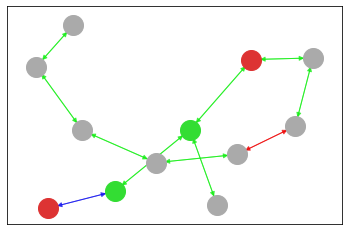

NO VALID ACTIONS
0


In [9]:
stateIdx = 56 

agentmol.paths_tree[stateIdx].show_visualization()

pairs = [] 

try: 
    state = agentmol.paths_tree[stateIdx] 

    new_states, actions = state.get_next_states(EnvMolecule.compare_state_to_mass_spec(state, agentmol.mass_spec, False), agentmol.paths_actions_tried[stateIdx],  return_actions=True) 

   
    for i in range(len(new_states)): 
        pairs.append((actions[i], new_states[i]))
except NoValidActionException: 
    print("NO VALID ACTIONS") 
        
print(len(pairs)) 


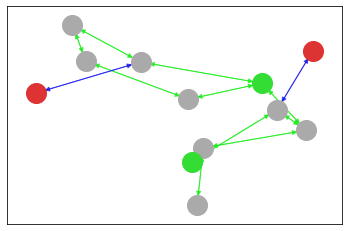

In [12]:
smiless = testdata[0]
MolState(smiless[0], utils.smiles_to_atom_counts(smiless[0]), utils.SMILEStoGraph(smiless[0]), 0, device).show_visualization()

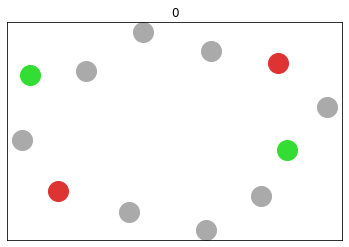

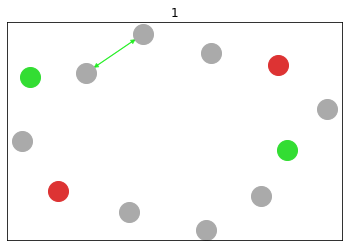

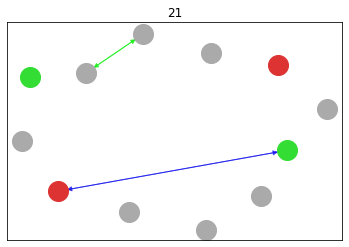

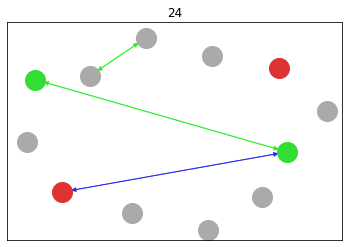

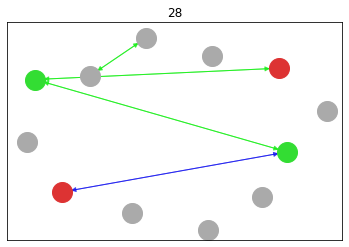

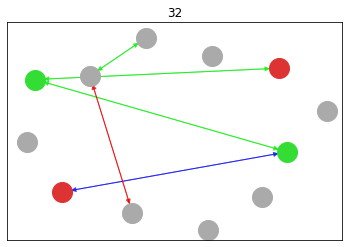

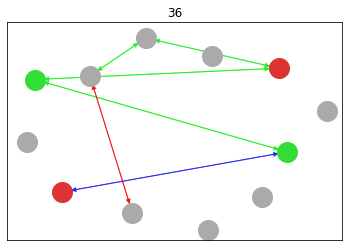

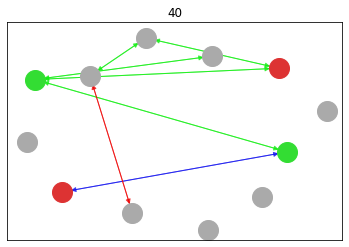

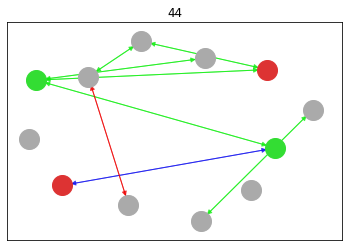

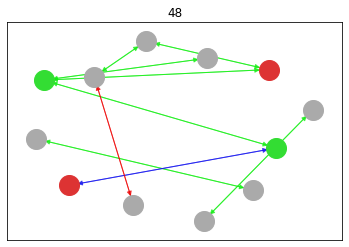

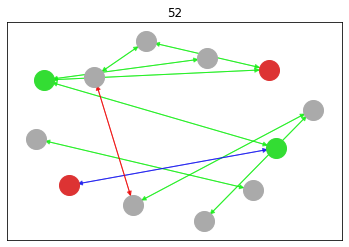

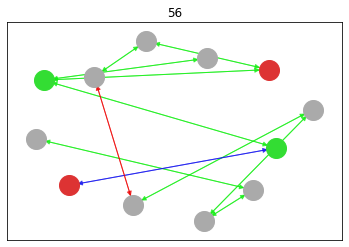

In [25]:
pl, path = utils.trace_path(agentmol, 56) 
utils.show_graphs(agentmol, path)

ACTIONS:
(1,6): 0 
(3,6): 0 
(5,6): 0 


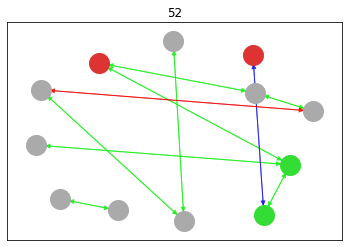

In [41]:
idx = 52 

print("ACTIONS:") 
state = agentmol.paths_tree[52] 
new_states, actions = state.get_next_states(EnvMolecule.compare_state_to_mass_spec(state, agentmol.mass_spec, False), [Action(4,6,0), Action(4,7,0)],  return_actions=True) 
for a in actions: 
    print('('+str(a.first)+','+str(a.second)+'): '+str(a.type)+' ') 

utils.show_graphs(agentmol, [idx])

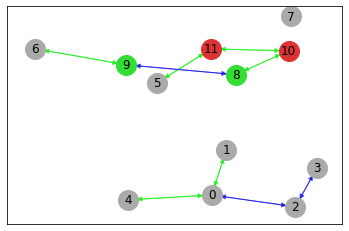

'\ng = dgl.to_networkx(agentmol.paths_tree[50].graph)\nedge_labels = {} \ni = 0 \nfor e in g.edges(): \n    edge_labels[e] = str(i//2) \n    i += 1 \n\nprint(edge_labels)\n'

In [86]:
def try_show_visualization(self, title=None, draw_edge_labels=False): 
    plt.figure() 

    # prepare 
    g = dgl.to_networkx(self.graph) 

    #stdout.write("Generating graph... \n")
    
    pos = nx.spring_layout(g, k=0.3, iterations=20) 

    #stdout.write("Drawing graph... \n")
    
    try_draw_visualization(self, g, pos, title, draw_edge_labels) 
    
def try_draw_visualization(self, g, pos, title=None, draw_edge_labels=False): 

    # draw each kind of node 
    node_options = {"node_size": 400, "node_shape": 'o'} 

    labels = {} 

    for nodeType in range(len(utils.FTreeNode.atomTypes)): 
        nt = nodeType 
        if nt==1: continue # Hydrogen 
        if nt>1: nt -= 1 

        nodes = [] 
        for nidx in range(len(self.graph.nodes())): 
            if self.graph.ndata['features'][nidx][nt+2].item() == 1: 
                nodes.append(nidx) 
                labels[nidx] = utils.FTreeNode.atomTypes[nodeType] 

        #print(nodeType, nt)
        #print("ATOM TYPE:", utils.FTreeNode.atomTypes[nodeType]) 
        #print("COLOUR:", utils.FTreeNode.atomColours[nodeType]) 
        nx.draw_networkx_nodes(g, pos, nodelist=nodes, node_color=utils.FTreeNode.atomColours[nodeType], **node_options) 

    # draw each kind of edge 

    edge_options = {"alpha": 0.7} 
    graph_edge_list = list(self.graph.edges()) 
    #print(graph_edge_list) 
    for edgeType in range(len(utils.bondTypes)): 
        edges = [] 
        for eidx in range(len(graph_edge_list[0])): 
            #print(self.graph.edata['bondTypes'][eidx][edgeType+1].item(), end=' ')
            if self.graph.edata['bondTypes'][eidx][edgeType+1].item() == 1: 
                edges.append((graph_edge_list[0][eidx].item(), graph_edge_list[1][eidx].item())) 
        #print() 
        #print(edgeType, ":", edges)
        nx.draw_networkx_edges(g, pos, edgelist=edges, edge_color=utils.edgeColors[edgeType], **edge_options)
    
    nx.draw_networkx_labels(g, pos)
    
    if draw_edge_labels: 
        edge_labels = {} 
        i = 0 
        for e in g.edges(): 
            edge_labels[e] = str(i//2) 
            i += 1 
        nx.draw_networkx_edge_labels(g, pos, edge_labels=edge_labels, font_size=8, alpha=0.5)

    if title != None: 
        plt.title(title) 

    plt.show() 

try_show_visualization(agentmol.paths_tree[50]) 

'''
g = dgl.to_networkx(agentmol.paths_tree[50].graph)
edge_labels = {} 
i = 0 
for e in g.edges(): 
    edge_labels[e] = str(i//2) 
    i += 1 

print(edge_labels)
'''